In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import RDLogger
import seaborn as sns

In [2]:
# Shutdown RDKit logging for cleaner output
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

### Reading data

In [3]:
train = pd.read_csv('../data/asap/train.tsv', sep='\t')
test = pd.read_csv('../data/asap/test.tsv', sep='\t')
train.shape, test.shape

((434, 6), (126, 1))

In [4]:
train

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.3,NaN,2.0
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2
2,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.4,NaN,0.5
3,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,NaN,8.5
4,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9
...,...,...,...,...,...,...
429,CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|,25.5,NaN,NaN,63.0,NaN
430,O=C(O)CC1=CC=CC=C1NC1=C(Cl)C=CC=C1Cl,216.0,NaN,NaN,386.0,NaN
431,NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1,NaN,NaN,2.0,NaN,NaN
432,COC(=O)NC1=NC2=CC=C(C(=O)C3=CC=CC=C3)C=C2N1,NaN,NaN,2.9,NaN,NaN


## Concern #1: clipping at an epsilon of 1e-8 creates extreme outliers in log scale

### Original properties distributions

In [6]:
def plot_distributions(columns):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    for i, col in enumerate(columns):
        sns.histplot(train[col], ax=ax[i])
        ax[i].set_title(col)
    plt.tight_layout()
    plt.show()

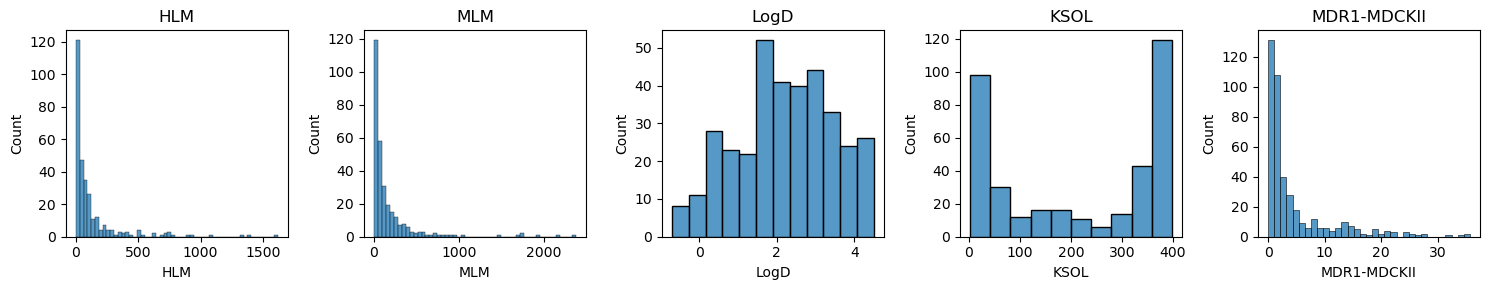

In [7]:
plot_distributions(['HLM', 'MLM', 'LogD', 'KSOL', 'MDR1-MDCKII'])

### Current evaluation's distributions

According to the [eval code for ADMET](https://github.com/asapdiscovery/asap-polaris-blind-challenge-examples/blob/506f8dc8bed420928fef46dc43307d33ed428472/evaulation.py#L177), the log10 scaling is applied after the clipping to a minimum of 1e-8. Let's reproduce it and look at the property distributions:

In [8]:
train['LogHLM'] = np.log10(np.clip(train['HLM'], a_min=1e-8, a_max=None))
train['LogMLM'] = np.log10(np.clip(train['MLM'], a_min=1e-8, a_max=None))
train['LogKSOL'] = np.log10(np.clip(train['KSOL'], a_min=1e-8, a_max=None))
train['LogMDR1-MDCKII'] = np.log10(np.clip(train['MDR1-MDCKII'], a_min=1e-8, a_max=None))

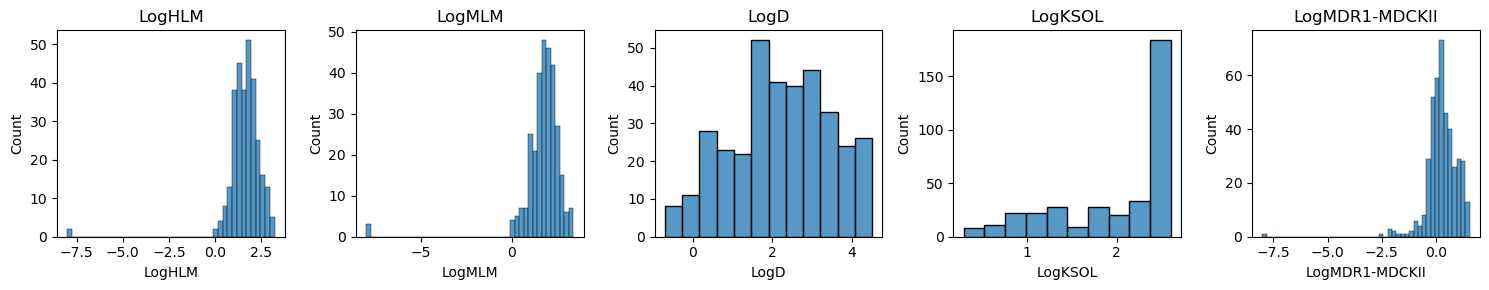

In [9]:
plot_distributions(['LogHLM', 'LogMLM', 'LogD', 'LogKSOL', 'LogMDR1-MDCKII'])

## Solution to concern #1

As can be seen from the log-scale distributions, we got extreme outliers at values of -8 for LogHLM, LogMLM, and LogMDR1-MDCKII. This is due to the fact that there were zeros in our original data and we changed them to `10^-8` by clipping. When applying log10 to these data points we get `log10(10^-8)=-8`.  These outliers impact the evaluation - while the model can predict values in-distribution, the evaluation penalizes it to predict the value far away from the overall distribution (which is not the case in the original scale).

To get rid of those outliers we can apply a per property epsilon that would make the log-scaled value be closer to the overall distribution of that property:

In [10]:
# Get top 10 smallest values for each property
pd.DataFrame({
    'HLM': train['HLM'].nsmallest(10).values,
    'MLM': train['MLM'].nsmallest(10).values,
    'KSOL': train['KSOL'].nsmallest(10).values, 
    'MDR1-MDCKII': train['MDR1-MDCKII'].nsmallest(10).values
})

,HLM,MLM,KSOL,MDR1-MDCKII
0,0.0,0.0,2.0,0.00000
1,0.0,0.0,2.0,0.00274
2,1.0,0.0,3.0,0.00854
3,1.0,1.0,3.0,0.00871
4,2.0,1.0,3.0,0.00929
5,2.0,1.0,3.0,0.01090
6,2.0,1.0,3.0,0.01420
7,2.0,2.0,3.0,0.02320
8,3.0,2.0,4.0,0.02370
9,3.0,2.0,4.0,0.04480


In [11]:
# By looking at the smallest non-zero values for each property, we can pick a better epsilon for each property
train['LogHLM'] = np.log10(np.clip(train['HLM'], a_min=0.5, a_max=None))
train['LogMLM'] = np.log10(np.clip(train['MLM'], a_min=0.5, a_max=None))
# train['LogKSOL'] = np.log10(np.clip(train['KSOL'], a_min=0.001, a_max=None))  # no need to clip
train['LogMDR1-MDCKII'] = np.log10(np.clip(train['MDR1-MDCKII'], a_min=0.001, a_max=None))

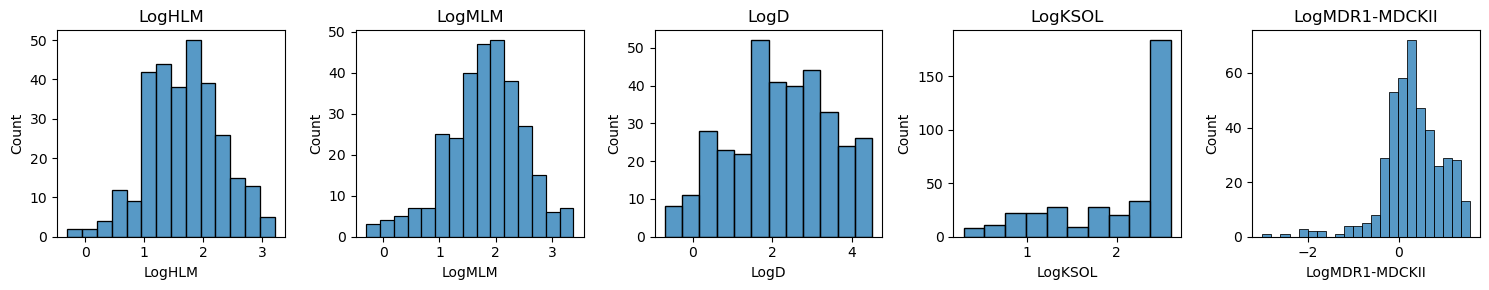

In [12]:
plot_distributions(['LogHLM', 'LogMLM', 'LogD', 'LogKSOL', 'LogMDR1-MDCKII'])

## Concern #2

Now let's asses the averaging part of [eval code](https://github.com/asapdiscovery/asap-polaris-blind-challenge-examples/blob/506f8dc8bed420928fef46dc43307d33ed428472/evaulation.py#L192). Even after distributions corretion we see that the distribution ranges for different properties vary a lot. For example, for LogHLM the range is somewhat from 0 to 3, and for LogMDR1-MDCKII it's somewhat from -3 to 2:

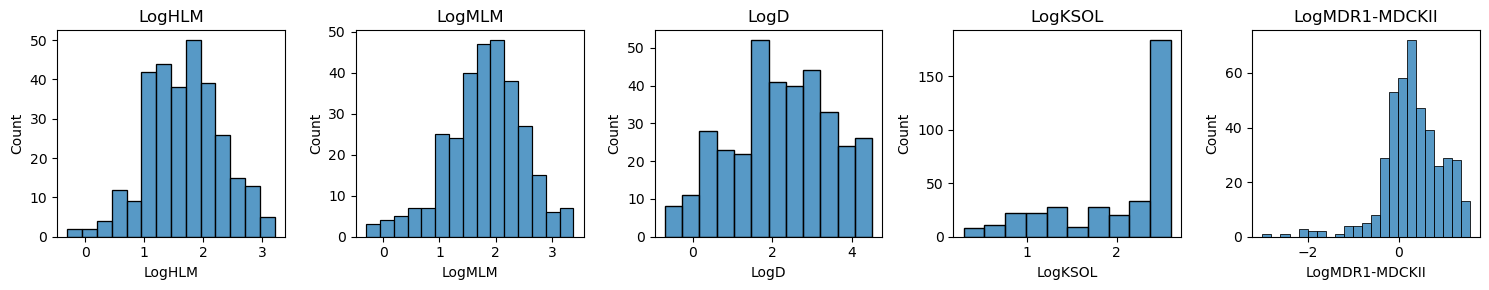

In [13]:
plot_distributions(['LogHLM', 'LogMLM', 'LogD', 'LogKSOL', 'LogMDR1-MDCKII'])

It means that we shouldn't apply macro averaging without any sort of weighting - the properties with wider range will dominate over the properties with more narrow range in the macro-averaged MAE.

### Solution to concern #2

We can have many options to address this issue, and let's start with the business goal. I assume we want to rank the models based on their average performance across different properties prediction. At the same time, we don't want outliers to crush our metric. Since we already moved away from outliers by log-scaling our data, we may not worry about them anymore. Due to the latter, the squared metrics like R2 could actually work but we still cannot average it as R2 is variance and scale dependent.   

Another option is to normailize MAE (or RMSE). We can do it in multiple ways, but I suggest to focus on simple min-max scaling: `nMAE_k = MAE_k / (max(y_k) - min(y_k))` for all `k` from 1 to 5 corresponding to different properties. After calculating normalized MAE, we can safely average for multi-output regression evaluation: `MAE = sum(nMAE_k for k in [1, 5]) / 5`. Since we already got rid of outliers, this metric becomes pretty stably and accounts for different property distributions.

## Eager to see your thoughts!